In [1]:
import numpy as np
import mrcfile
from matplotlib import pyplot as plt
%matplotlib inline
import collections
import tensorflow as tf
from tensorflow import spectral
from ClassFiles.relion_fixed_it import load_star
from ClassFiles.Framework import AdversarialRegulariser 
from ClassFiles.ut import l2

In [16]:
base_path = '/local/scratch/public/sl767/MRC_Data/Data_002_10k/EM/'
#path=base_path+'Refine3D/1H12/1H12_mult002_it007_half2_class001_external_reconstruct.star'
#path=base_path+'Refine3D/1H12/1H12_mult005_it001_half1_class001_external_reconstruct.star'
path=base_path+'1O20/1O20_mult002_it001_half1_class001_external_reconstruct.star'

sgd_path='/local/scratch/public/sl767/MRC_Data/Data_002_10k/SGD/1O20/1O20_mult002_it300_class001.mrc'

In [17]:
file=load_star(path)

In [18]:
with mrcfile.open(file['external_reconstruct_general']['rlnExtReconsDataReal']) as mrc:
   data_real = mrc.data
with mrcfile.open(file['external_reconstruct_general']['rlnExtReconsDataImag']) as mrc:
   data_im = mrc.data
with mrcfile.open(file['external_reconstruct_general']['rlnExtReconsWeight']) as mrc:
   kernel = mrc.data
# with mrcfile.open(path) as mrc:
#     sgd_res = mrc.data
with mrcfile.open(sgd_path) as mrc:
   sgd_data = mrc.data

4.62962


In [19]:
complex_data=data_real + 1j * data_im

In [20]:
target_path = base_path+file['external_reconstruct_general']['rlnExtReconsResult']

In [21]:
REGULARIZATION=.03
set_off=REGULARIZATION*kernel.mean()
reg_kernel = kernel+set_off

In [22]:
# Initial guess for iterative algorithm
# reco = np.divide(complex_data,reg_kernel)
# ini = np.copy(reco)
reco = np.fft.rfftn(np.fft.ifftshift(sgd_data))
ini = np.copy(reco)

Build visualization tool

In [23]:
def vis(data):
    im = np.fft.fftshift(np.fft.irfftn(data))
    plt.imshow(im[...,45])

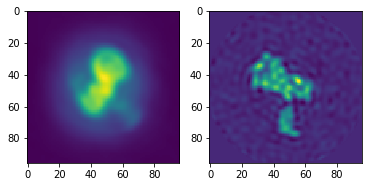

In [24]:
plt.subplot(121)
vis(complex_data)
plt.subplot(122)
vis(reco)

In [11]:
saves_path = '/local/scratch/public/sl767/SPA/Saves/Adversarial_Regulariser/SGD_Trained'
regularizer = AdversarialRegulariser(saves_path)

INFO:tensorflow:Restoring parameters from /local/scratch/public/sl767/SPA/Saves/Adversarial_Regulariser/SGD_Trained/Data/model-11000
Save restored


In [12]:
STEP_SIZE=5e4
def grad(image):
    grad = regularizer.evaluate(image)
    return grad

In [13]:
# plt.subplot(131)
# vis(ini)
# plt.subplot(132)
# gradient = grad(reco)
# vis(gradient)
# reco=reco-STEP_SIZE*(gradient-9.0675324549243569e-07*ini)
# plt.subplot(133)
# vis(reco)

In [14]:
# for k in range(500):
#     STEP_SIZE=1e-2
#     gradient = grad(reco)
#     reco = reco - STEP_SIZE*(gradient*(96**3)+7*(reco-ini))
#     if k%50==0:
#         plt.figure(k)
#         plt.subplot(121)
#         vis(reco)
#         plt.subplot(122)
#         vis(ini)
#         plt.show()

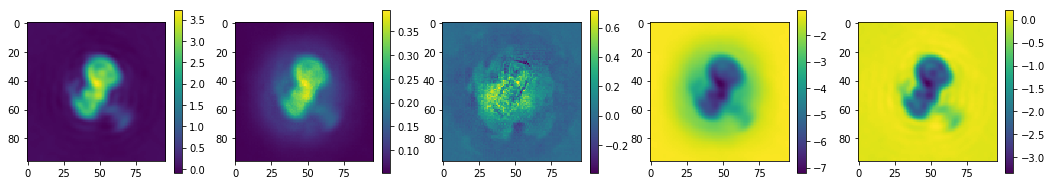

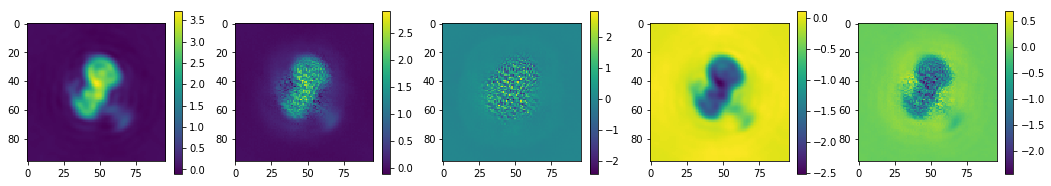

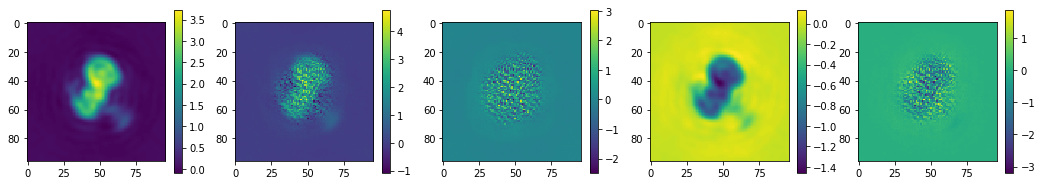

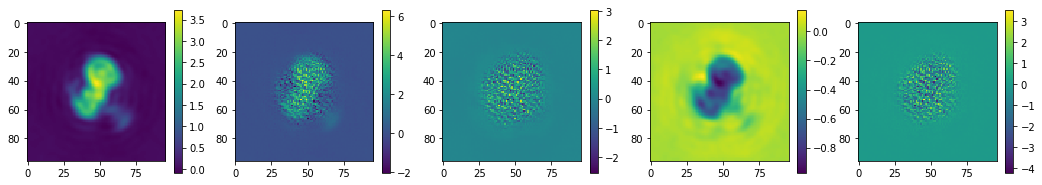

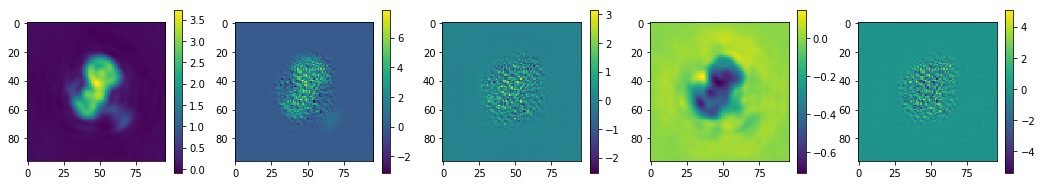

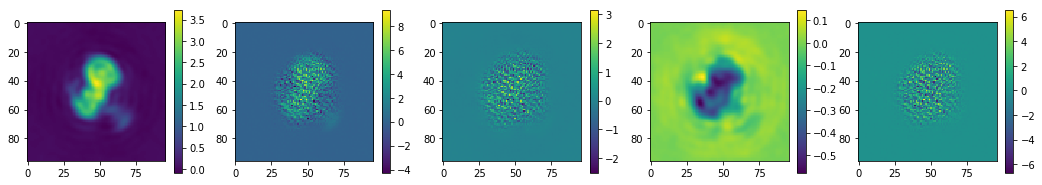

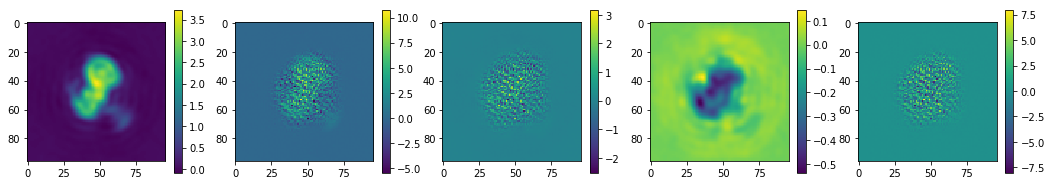

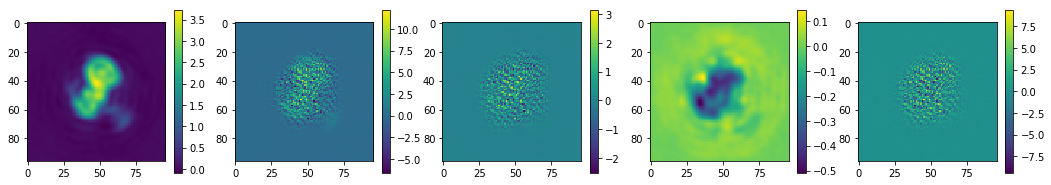

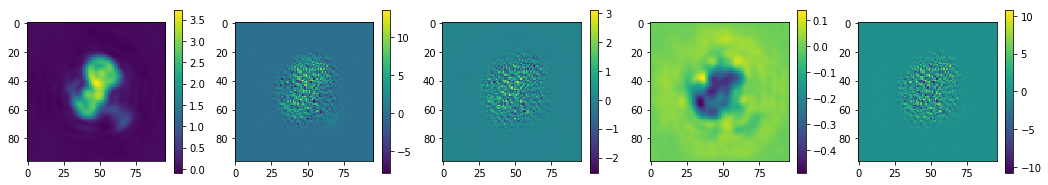

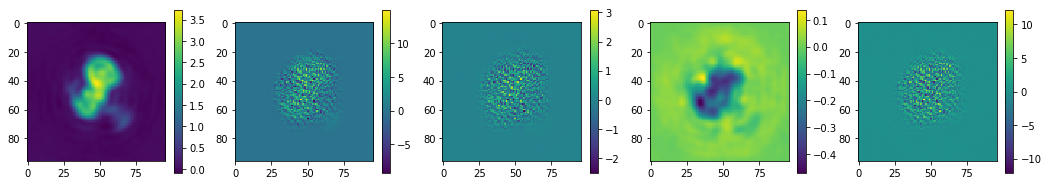

In [31]:
# reco = np.copy(ini) * 1e-9
tikhonov = np.divide(complex_data, kernel + 1e6)
reco = np.copy(tikhonov) * 1e-2

# The scales produce gradients of order 1
ADVERSARIAL_SCALE=(96**1.5)
DATA_SCALE=1/(10*96**3)

IMAGING_SCALE=96**3

for k in range(100):
    STEP_SIZE=5e-2
    g1 = 0.07 * grad(reco) * ADVERSARIAL_SCALE
    g2 = DATA_SCALE*(np.multiply(reco, kernel + 1) - complex_data)
    g3 = 0 # 1e-2 * (reco - ini)
    reco = reco - STEP_SIZE*(g1 + g2 + g3)
    if k%10==0:
        plt.figure(k, figsize=(18,3))
        plt.subplot(151)
        vis(IMAGING_SCALE*tikhonov)
        plt.colorbar()
        plt.subplot(152)
        vis(IMAGING_SCALE*reco)
        plt.colorbar()
        plt.subplot(153)
        vis(IMAGING_SCALE*g1)
        plt.colorbar()
        plt.subplot(154)
        vis(IMAGING_SCALE*g2)
        plt.colorbar()
        plt.subplot(155)
        vis(IMAGING_SCALE*(reco - tikhonov))
        plt.colorbar()
        plt.show()

l2(np.multiply(reco, kernel)-complex_data)

In [ ]:
norm_ini = l2(ini)
print(norm_ini)

In [ ]:
norm_grad = l2(grad(ini))
print(norm_grad*(96**1.5))

In [ ]:
norm_grad_data = l2(np.multiply(kernel,ini)-complex_data)
print(norm_grad_data)

In [ ]:
l2(np.multiply(kernel, ini))

In [ ]:
l2(complex_data) * 96 ** 3

In [ ]:
l2(np.divide(complex_data, kernel+100))

In [ ]:
l2(ini)

In [ ]:
l2(kernel)

In [ ]:
98**3 * l2(np.divide(complex_data, kernel+1))

In [ ]:
np.mean(np.abs(kernel))

In [ ]:
plt.imshow(np.log(1e6 + np.abs(kernel)[...,0]))
plt.colorbar()

In [ ]:
plt.imshow(np.log10(1 + np.abs(kernel)[...,0]), clim=[6, 7])
plt.colorbar()

In [ ]:
plt.imshow(np.log10(1 + np.abs(complex_data)[...,0]))
plt.colorbar()

In [ ]:
l2(kernel)

In [ ]:
l2(complex_data)/(96**3)

In [ ]:
l2(np.divide(complex_data, kernel+1))

In [ ]:
l2(kernel)/(96**3)

In [ ]:
l2(grad())